In [4]:
import setup
setup.init_django()
from market import services as market_services
from market import tasks as market_tasks
from market.models import Company
import json
from decouple import config

In [5]:
ticker = "AAPL"
name = "Apple"
company, _ = Company.objects.get_or_create(name=name, ticker=ticker)
company.id

2

In [6]:
market_tasks.sync_historical_stock_data(
    years_ago=1, 
    company_ids=[company.id], 
    use_celery=False, 
    verbose=True
)

#use celery / async
#market_tasks.sync_historical_stock_data.delay(years_ago=5, company_ids=[company.id], use_celery=True, verbose=False)

Historical sync days ago 30
dataset length 3411
Doing chunk 0
finished chunk 0
Doing chunk 1000
finished chunk 1000
Doing chunk 2000
finished chunk 2000
Doing chunk 3000
finished chunk 3000
30 done

Historical sync days ago 60
dataset length 7105
Doing chunk 0
finished chunk 0
Doing chunk 1000
finished chunk 1000
Doing chunk 2000
finished chunk 2000
Doing chunk 3000
finished chunk 3000
Doing chunk 4000
finished chunk 4000
Doing chunk 5000
finished chunk 5000
Doing chunk 6000
finished chunk 6000
Doing chunk 7000
finished chunk 7000
60 done

Historical sync days ago 90
dataset length 10974
Doing chunk 0
finished chunk 0
Doing chunk 1000
finished chunk 1000
Doing chunk 2000
finished chunk 2000
Doing chunk 3000
finished chunk 3000
Doing chunk 4000
finished chunk 4000
Doing chunk 5000
finished chunk 5000
Doing chunk 6000
finished chunk 6000
Doing chunk 7000
finished chunk 7000
Doing chunk 8000
finished chunk 8000
Doing chunk 9000
finished chunk 9000
Doing chunk 10000
finished chunk 10000
90

In [7]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [8]:
import pandas as pd
from market import services as market_services

days = 365
queryset = market_services.get_daily_stock_quotes_queryset(ticker, days=days)

historical_data = list(queryset.values(
    'time', 'open_price', 'close_price', 'high_price', 'low_price',
    'raw_timestamp', 'number_of_trades', 'volume', 'volume_weighted_average'
))
data = pd.DataFrame(historical_data)
data.head()


,time,open_price,close_price,high_price,low_price,raw_timestamp,number_of_trades,volume,volume_weighted_average
0,2024-02-20 23:55:00+00:00,181.6300,181.7000,181.7000,181.6300,1708473300000,41,1376,181.654800
1,2024-02-21 23:55:00+00:00,182.5000,182.4700,182.5645,182.3700,1708559700000,88,8744,182.418600
2,2024-02-22 23:55:00+00:00,184.2400,184.2400,184.2400,184.2400,1708646100000,35,953,184.238800
3,2024-02-23 23:55:00+00:00,182.3200,182.3300,182.3300,182.3100,1708732500000,59,2747,182.315700
4,2024-02-24 00:55:00+00:00,182.3100,182.2800,182.3100,182.2300,1708736100000,115,6158,182.265700


In [9]:
data = data[['time','close_price']]
data

,time,close_price
0,2024-02-20 23:55:00+00:00,181.7000
1,2024-02-21 23:55:00+00:00,182.4700
2,2024-02-22 23:55:00+00:00,184.2400
3,2024-02-23 23:55:00+00:00,182.3300
4,2024-02-24 00:55:00+00:00,182.2800
...,...,...
241,2025-01-14 23:55:00+00:00,233.3500
242,2025-01-15 23:55:00+00:00,238.2735
243,2025-01-16 23:55:00+00:00,228.4700
244,2025-01-17 23:55:00+00:00,229.8226


In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

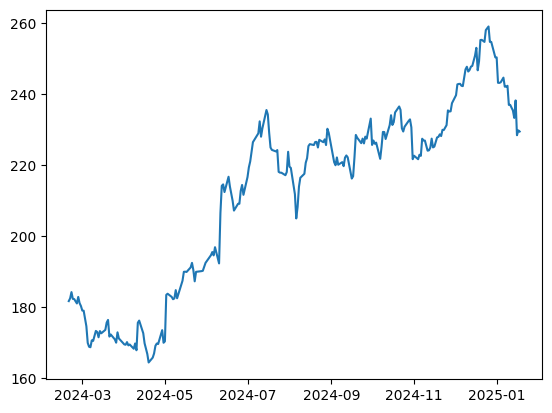

In [11]:
data['time'] = pd.to_datetime(data['time']).dt.date
plt.plot(data['time'], data['close_price'])

In [12]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('time', inplace=True)

    for i in range(1, n_steps+1):
        df[f'close_price(t-{i})'] = df['close_price'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,close_price,close_price(t-1),close_price(t-2),close_price(t-3),close_price(t-4),close_price(t-5),close_price(t-6),close_price(t-7)
time,,,,,,,,
2024-02-28,181.1200,182.8800,181.0400,182.2800,182.3300,184.2400,182.4700,181.7000
2024-02-29,180.3059,181.1200,182.8800,181.0400,182.2800,182.3300,184.2400,182.4700
2024-03-01,179.0307,180.3059,181.1200,182.8800,181.0400,182.2800,182.3300,184.2400
2024-03-02,179.0000,179.0307,180.3059,181.1200,182.8800,181.0400,182.2800,182.3300
2024-03-04,174.6100,179.0000,179.0307,180.3059,181.1200,182.8800,181.0400,182.2800
...,...,...,...,...,...,...,...,...
2025-01-14,233.3500,235.4300,237.0200,237.0100,242.4000,242.1600,242.1500,244.7006
2025-01-15,238.2735,233.3500,235.4300,237.0200,237.0100,242.4000,242.1600,242.1500
2025-01-16,228.4700,238.2735,233.3500,235.4300,237.0200,237.0100,242.4000,242.1600


In [13]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[Decimal('181.1200'), Decimal('182.8800'), Decimal('181.0400'),
        ..., Decimal('184.2400'), Decimal('182.4700'),
        Decimal('181.7000')],
       [Decimal('180.3059'), Decimal('181.1200'), Decimal('182.8800'),
        ..., Decimal('182.3300'), Decimal('184.2400'),
        Decimal('182.4700')],
       [Decimal('179.0307'), Decimal('180.3059'), Decimal('181.1200'),
        ..., Decimal('182.2800'), Decimal('182.3300'),
        Decimal('184.2400')],
       ...,
       [Decimal('228.4700'), Decimal('238.2735'), Decimal('233.3500'),
        ..., Decimal('237.0100'), Decimal('242.4000'),
        Decimal('242.1600')],
       [Decimal('229.8226'), Decimal('228.4700'), Decimal('238.2735'),
        ..., Decimal('237.0200'), Decimal('237.0100'),
        Decimal('242.4000')],
       [Decimal('229.4990'), Decimal('229.8226'), Decimal('228.4700'),
        ..., Decimal('235.4300'), Decimal('237.0200'),
        Decimal('237.0100')]], dtype=object)

In [14]:
shifted_df_as_np.shape

(239, 8)

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.64695946, -0.6097973 , -0.64864865, ..., -0.58108108,
        -0.61845439, -0.63471284],
       [-0.66414907, -0.64695946, -0.6097973 , ..., -0.62141047,
        -0.58108108, -0.61845439],
       [-0.69107475, -0.66414907, -0.64695946, ..., -0.62246622,
        -0.62141047, -0.58108108],
       ...,
       [ 0.35282939,  0.55982897,  0.45586993, ...,  0.53315034,
         0.64695946,  0.64189189],
       [ 0.38138936,  0.35282939,  0.55982897, ...,  0.53336149,
         0.53315034,  0.64695946],
       [ 0.37455659,  0.38138936,  0.35282939, ...,  0.49978885,
         0.53336149,  0.53315034]])

In [16]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((239, 7), (239,))

In [17]:
X = dc(np.flip(X, axis=1))
X

array([[-0.63471284, -0.61845439, -0.58108108, ..., -0.62246622,
        -0.64864865, -0.6097973 ],
       [-0.61845439, -0.58108108, -0.62141047, ..., -0.64864865,
        -0.6097973 , -0.64695946],
       [-0.58108108, -0.62141047, -0.62246622, ..., -0.6097973 ,
        -0.64695946, -0.66414907],
       ...,
       [ 0.64189189,  0.64695946,  0.53315034, ...,  0.49978885,
         0.45586993,  0.55982897],
       [ 0.64695946,  0.53315034,  0.53336149, ...,  0.45586993,
         0.55982897,  0.35282939],
       [ 0.53315034,  0.53336149,  0.49978885, ...,  0.55982897,
         0.35282939,  0.38138936]])

In [18]:
split_index = int(len(X) * 0.95)

split_index

227

In [19]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227, 7), (12, 7), (227,), (12,))

In [20]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227, 7, 1), (12, 7, 1), (227, 1), (12, 1))

In [21]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([227, 7, 1]),
 torch.Size([12, 7, 1]),
 torch.Size([227, 1]),
 torch.Size([12, 1]))

In [22]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [23]:
train_dataset

In [24]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [27]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99: 
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [28]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print()

In [38]:
learning_rate = 0.001
num_epochs = 45
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.009

Epoch: 2

Val Loss: 0.009

Epoch: 3

Val Loss: 0.011

Epoch: 4

Val Loss: 0.013

Epoch: 5

Val Loss: 0.012

Epoch: 6

Val Loss: 0.012

Epoch: 7

Val Loss: 0.013

Epoch: 8

Val Loss: 0.013

Epoch: 9

Val Loss: 0.013

Epoch: 10

Val Loss: 0.015

Epoch: 11

Val Loss: 0.016

Epoch: 12

Val Loss: 0.014

Epoch: 13

Val Loss: 0.015

Epoch: 14

Val Loss: 0.015

Epoch: 15

Val Loss: 0.016

Epoch: 16

Val Loss: 0.016

Epoch: 17

Val Loss: 0.016

Epoch: 18

Val Loss: 0.013

Epoch: 19

Val Loss: 0.014

Epoch: 20

Val Loss: 0.013

Epoch: 21

Val Loss: 0.015

Epoch: 22

Val Loss: 0.015

Epoch: 23

Val Loss: 0.012

Epoch: 24

Val Loss: 0.013

Epoch: 25

Val Loss: 0.015

Epoch: 26

Val Loss: 0.012

Epoch: 27

Val Loss: 0.013

Epoch: 28

Val Loss: 0.012

Epoch: 29

Val Loss: 0.012

Epoch: 30

Val Loss: 0.014

Epoch: 31

Val Loss: 0.012

Epoch: 32

Val Loss: 0.012

Epoch: 33

Val Loss: 0.013

Epoch: 34

Val Loss: 0.011

Epoch: 35

Val Loss: 0.012

Epoch: 36

Val Loss: 0.013

E

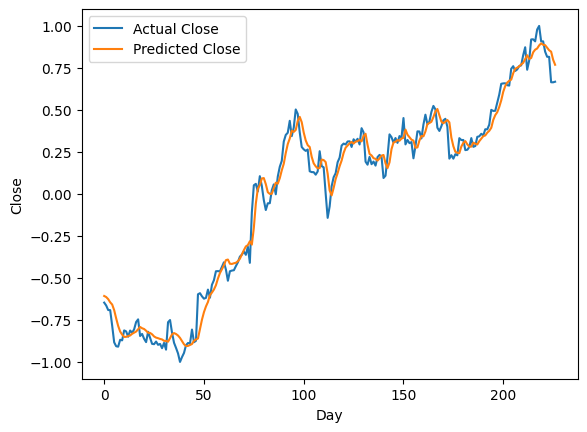

In [39]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [40]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([182.9865889 , 182.6868277 , 182.10201813, 181.20809235,
       180.57787399, 178.99425186, 176.67737076, 174.54691238,
       172.96247726, 172.08968918, 171.45223862, 171.45963455,
       171.69876038, 171.85765442, 172.32682205, 172.63161926,
       172.96059723, 173.62620316, 174.25560287, 173.89172287,
       173.67978134, 173.19522339, 172.62140045, 172.57310669,
       172.18600006, 171.58318054, 171.25048767, 171.08834167,
       170.87676147, 170.73415543, 170.34744965, 170.31961609,
       170.09873169, 171.10276657, 172.18803253, 172.5293634 ,
       172.2727301 , 171.84083572, 171.16901382, 170.245047  ,
       169.37397522, 168.87198318, 168.90951614, 169.1660083 ,
       169.44575531, 170.35921539, 170.72994934, 170.99626511,
       173.64112488, 176.31124939, 178.43414246, 180.03864822,
       181.29513855, 183.23226097, 183.94950577, 184.81038979,
       186.02397522, 187.89637192, 189.43740532, 190.50627319,
       191.65473206, 193.10079544, 193.25950882, 192.08

In [41]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([181.11999886, 180.30590118, 179.03070084, 178.99999924,
       174.61000084, 169.9200013 , 168.81999992, 168.69999947,
       170.64810005, 170.48000061, 173.28999863, 172.99999893,
       171.49999886, 173.2500013 , 172.62999893, 173.58999977,
       175.64999916, 176.40000061, 171.69990082, 172.29000046,
       170.91999947, 169.9799987 , 172.90000137, 171.18000046,
       169.49999969, 169.39999931, 170.13999931, 169.21999863,
       169.47000099, 168.26999924, 169.76000069, 167.85000046,
       175.59989876, 176.2100013 , 172.64999901, 169.80000084,
       168.34999954, 166.80000069, 164.4       , 165.77000099,
       166.94000122, 169.10000099, 169.74000061, 169.60000008,
       173.52000092, 169.95999863, 170.3499987 , 183.45999931,
       183.78000053, 182.89000137, 182.22999886, 182.46000114,
       184.79000015, 182.5000013 , 186.14000107, 187.44999901,
       189.96000011, 190.00000027, 189.91999996, 191.19000057,
       192.47999985, 190.46000061, 187.27999977, 189.95

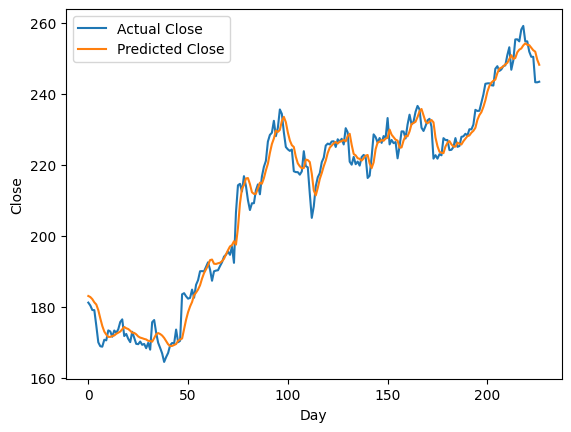

In [42]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [43]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([247.23143242, 246.88553131, 245.74534348, 245.00500755,
       244.54153931, 242.44070702, 241.00493866, 239.32898872,
       237.21017754, 237.8856974 , 234.27268715, 232.26272324])

In [44]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([244.7005999 , 242.14999878, 242.16000023, 242.40000114,
       237.00999893, 237.02000038, 235.42999996, 233.3500005 ,
       238.27350128, 228.47000023, 229.8225996 , 229.49900063])

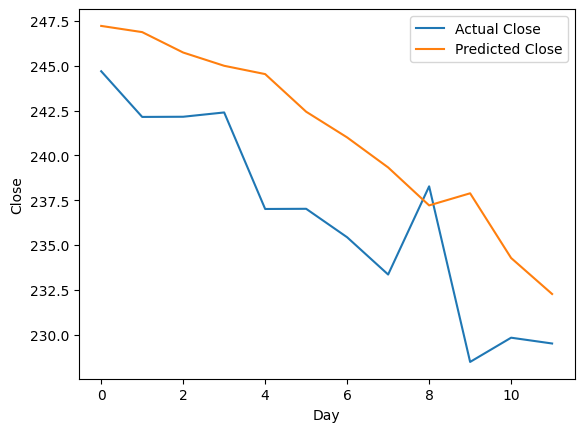

In [45]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

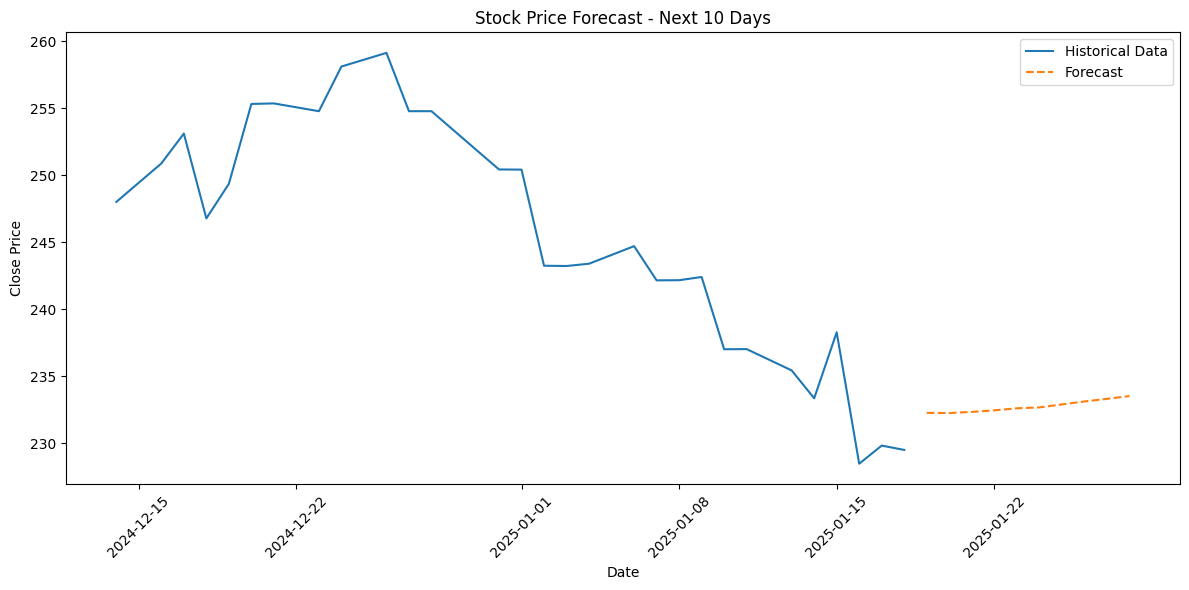


Forecasted values for next 10 days:
         Date  Forecasted_Close
0  2025-01-19        232.262723
1  2025-01-20        232.250393
2  2025-01-21        232.336309
3  2025-01-22        232.450274
4  2025-01-23        232.604232
5  2025-01-24        232.669512
6  2025-01-25        232.892946
7  2025-01-26        233.113235
8  2025-01-27        233.307882
9  2025-01-28        233.515983


In [46]:
last_sequence = X_test[-1:].to(device)
next_10_days_pred = []

for _ in range(10):
    with torch.no_grad():
        next_day = model(last_sequence).cpu().numpy()[0][0]
    next_10_days_pred.append(next_day)

    new_sequence = last_sequence.cpu().numpy()[0][1:]
    new_sequence = np.append(new_sequence, next_day)
    last_sequence = torch.tensor(new_sequence.reshape(1, lookback, 1)).float().to(device)

dummies = np.zeros((len(next_10_days_pred), lookback+1))
dummies[:, 0] = next_10_days_pred
dummies = scaler.inverse_transform(dummies)
next_10_days_pred = dc(dummies[:, 0])

last_date = data['time'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=11)[1:].date

plt.figure(figsize=(12, 6))
plt.plot(data['time'][-30:], data['close_price'][-30:], label='Historical Data')
plt.plot(forecast_dates, next_10_days_pred, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Forecast - Next 10 Days')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Close': next_10_days_pred
})
print("\nForecasted values for next 10 days:")
print(forecast_df)